In [101]:
import pandas as pd
import geopandas as gpd
import fiona
import shapely.geometry as geometry
import os

### Open Data

In [50]:
crime = pd.read_csv("./data/open_data_dc/Crime_Incidents_in_2019.csv")
neighborhood_gdb_path = "/Users/rebeccawagner/Desktop/Zillow_Neighborhoods/ZillowNeighborhoods.gdb"

### Extract Neighborhoods from Geodatabase

In [52]:
layers = fiona.listlayers(neighborhood_gdb_path) # inspect whats in the gdb
layers

['ZillowNeighborhoods_GeoDD',
 'ZillowNeighborhoodsAreas',
 'ZillowNeighborhoodsCentroids']

In [54]:
areas = gpd.read_file(neighborhood_gdb_path, layer="ZillowNeighborhoodsAreas") # open boundaries layer
areas_dc = areas[areas["State"] == "DC"] # isolate DC data

areas_dc.head()

,State,County,City,Name,RegionID,Shape_Length,Shape_Area,geometry
3985,DC,District of Columbia,Washington,Barnaby Woods,121672,6487.711892,1.588581e+06,"MULTIPOLYGON (((-8576641.772 4718197.233, -857..."
3986,DC,District of Columbia,Washington,Bellevue,121674,13009.684045,4.414694e+06,"MULTIPOLYGON (((-8573425.727 4694395.929, -857..."
3987,DC,District of Columbia,Washington,Benning,121675,4189.894253,7.754994e+05,"MULTIPOLYGON (((-8566062.749 4705886.248, -856..."
3988,DC,District of Columbia,Washington,Chevy Chase,121689,13271.415611,8.615037e+06,"MULTIPOLYGON (((-8577527.697 4717791.59, -8577..."
3989,DC,District of Columbia,Washington,Dupont Park,121705,8866.831877,4.097278e+06,"MULTIPOLYGON (((-8565708.624 4704906.644, -856..."


In [57]:
neighborhoods = gpd.read_file(neighborhood_gdb_path, layer="ZillowNeighborhoods_GeoDD") # open areas layer
neighborhoods_dc = neighborhoods[neighborhoods["State"] == "DC"] # isolate dc data

neighborhoods_dc.head()

,State,County,City,Name,RegionID,Shape_Length,Shape_Area,geometry
3985,DC,District of Columbia,Washington,Barnaby Woods,121672,0.055897,0.000100,"MULTIPOLYGON (((-77.04528 38.97573, -77.04544 ..."
3986,DC,District of Columbia,Washington,Bellevue,121674,0.098046,0.000278,"MULTIPOLYGON (((-77.01639 38.80932, -77.01753 ..."
3987,DC,District of Columbia,Washington,Benning,121675,0.035517,0.000049,"MULTIPOLYGON (((-76.95025 38.88971, -76.95309 ..."
3988,DC,District of Columbia,Washington,Chevy Chase,121689,0.105985,0.000541,"MULTIPOLYGON (((-77.05324 38.9729, -77.04936 3..."
3989,DC,District of Columbia,Washington,Dupont Park,121705,0.071236,0.000257,"MULTIPOLYGON (((-76.94707 38.88286, -76.94673 ..."


<Axes: >

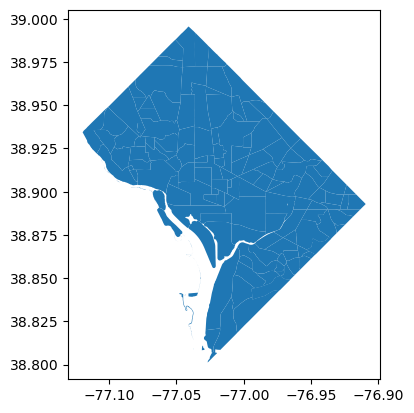

In [78]:
neighborhoods_dc.plot()

### Map Crime into Neighborhoods

In [79]:
crime.columns

Index(['X', 'Y', 'CCN', 'REPORT_DAT', 'SHIFT', 'METHOD', 'OFFENSE', 'BLOCK',
       'XBLOCK', 'YBLOCK', 'WARD', 'ANC', 'DISTRICT', 'PSA',
       'NEIGHBORHOOD_CLUSTER', 'BLOCK_GROUP', 'CENSUS_TRACT',
       'VOTING_PRECINCT', 'LATITUDE', 'LONGITUDE', 'BID', 'START_DATE',
       'END_DATE', 'OBJECTID', 'OCTO_RECORD_ID'],
      dtype='object')

In [81]:
crime["geom"] = [geometry.Point(xy) for xy in zip(crime["LONGITUDE"], crime["LATITUDE"])] # create point geometry for each crime
crime_gdf = gpd.GeoDataFrame(crime) # convert to geodataframe

In [93]:
crime_gdf = crime_gdf.set_geometry("geom") # set geometry 
crime_gdf = crime_gdf.set_crs(neighborhoods_dc.crs, allow_override=True) # set coordinate system to match zillow data

In [100]:
crime_with_neighborhoods = gpd.sjoin(crime_gdf,neighborhoods_dc,how="left",predicate="within")
crime_with_neighborhoods[list(crime.columns) + ["Name"]].head() # success! All crime stats are now assigned to a neighborhood

,X,Y,CCN,REPORT_DAT,SHIFT,METHOD,OFFENSE,BLOCK,XBLOCK,YBLOCK,...,VOTING_PRECINCT,LATITUDE,LONGITUDE,BID,START_DATE,END_DATE,OBJECTID,OCTO_RECORD_ID,geom,Name
0,404536.0,135167.0,19153575,2019/08/30 07:39:01+00,MIDNIGHT,KNIFE,ASSAULT W/DANGEROUS WEAPON,400 - 439 BLOCK OF RIDGE ROAD SE,404536.0,135167.0,...,Precinct 107,38.884329,-76.947720,NaN,2019/08/30 03:54:53+00,2019/08/30 07:24:00+00,630055700,NaN,POINT (-76.94772 38.88433),Fort Dupont
1,398739.0,138827.0,19153798,2019/08/31 09:45:49+00,MIDNIGHT,OTHERS,THEFT/OTHER,1950 - 2035 BLOCK OF 2ND STREET NW,398739.0,138827.0,...,Precinct 20,38.917310,-77.014541,NaN,2019/08/28 21:27:33+00,2019/08/28 21:29:34+00,630055701,NaN,POINT (-77.01454 38.91731),Ledroit Park
2,399612.0,137531.0,19011571,2019/01/21 05:14:53+00,MIDNIGHT,OTHERS,THEFT/OTHER,100 - 199 BLOCK OF M STREET NE,399612.0,137531.0,...,Precinct 144,38.905636,-77.004473,NOMA,2019/01/21 04:26:25+00,2019/01/21 04:57:28+00,630055843,NaN,POINT (-77.00447 38.90564),NoMa
3,403550.0,139245.0,19011760,2019/01/21 18:26:47+00,DAY,OTHERS,THEFT F/AUTO,2240 - 2399 BLOCK OF SOUTH DAKOTA AVENUE NE,403550.0,139245.0,...,Precinct 71,38.921070,-76.959063,NaN,2019/01/21 17:31:23+00,NaN,630055844,NaN,POINT (-76.95906 38.92107),Fort Lincoln
4,391066.0,139692.0,19012480,2019/01/23 00:14:00+00,EVENING,OTHERS,THEFT F/AUTO,5100 - 5199 BLOCK OF SHERIER PLACE NW,391066.0,139692.0,...,Precinct 8,38.925058,-77.103029,NaN,2019/01/22 12:45:40+00,2019/01/22 23:05:10+00,630055845,NaN,POINT (-77.10303 38.92506),The Palisades


### Put it in a loop and do it for all the crime data we have

In [110]:
files = [file for file in os.listdir("./data/open_data_dc/") if (file.endswith(".csv")) & (len(file)==27)]
files

['Crime_Incidents_in_2021.csv',
 'Crime_Incidents_in_2020.csv',
 'Crime_Incidents_in_2022.csv',
 'Crime_Incidents_in_2023.csv',
 'Crime_Incidents_in_2024.csv',
 'Crime_Incidents_in_2019.csv']

In [114]:
for file in files: 

    #open file
    crime = pd.read_csv("./data/open_data_dc/" + file)

    crime["geom"] = [geometry.Point(xy) for xy in zip(crime["LONGITUDE"], crime["LATITUDE"])] # create point geometry for each crime
    crime_gdf = gpd.GeoDataFrame(crime) # convert to geodataframe

    crime_gdf = crime_gdf.set_geometry("geom") # set geometry 
    crime_gdf = crime_gdf.set_crs(neighborhoods_dc.crs, allow_override=True) # set coordinate system to match zillow data

    crime_with_neighborhoods = gpd.sjoin(crime_gdf,neighborhoods_dc,how="left",predicate="within")
    crime_with_neighborhoods = crime_with_neighborhoods[list(crime.columns) + ["Name"]] # grab columns we want 

    # save
    save_name = file.split('.')[0] + "_with_neighborhood.csv"
    crime_with_neighborhoods.to_csv("./data/open_data_dc/" + save_name)

In [113]:
crime_with_neighborhoods

,X,Y,CCN,REPORT_DAT,SHIFT,METHOD,OFFENSE,BLOCK,XBLOCK,YBLOCK,...,VOTING_PRECINCT,LATITUDE,LONGITUDE,BID,START_DATE,END_DATE,OBJECTID,OCTO_RECORD_ID,geom,Name
0,404536.0,135167.0,19153575,2019/08/30 07:39:01+00,MIDNIGHT,KNIFE,ASSAULT W/DANGEROUS WEAPON,400 - 439 BLOCK OF RIDGE ROAD SE,404536.0,135167.0,...,Precinct 107,38.884329,-76.947720,NaN,2019/08/30 03:54:53+00,2019/08/30 07:24:00+00,630055700,NaN,POINT (-76.94772 38.88433),Fort Dupont
1,398739.0,138827.0,19153798,2019/08/31 09:45:49+00,MIDNIGHT,OTHERS,THEFT/OTHER,1950 - 2035 BLOCK OF 2ND STREET NW,398739.0,138827.0,...,Precinct 20,38.917310,-77.014541,NaN,2019/08/28 21:27:33+00,2019/08/28 21:29:34+00,630055701,NaN,POINT (-77.01454 38.91731),Ledroit Park
2,399612.0,137531.0,19011571,2019/01/21 05:14:53+00,MIDNIGHT,OTHERS,THEFT/OTHER,100 - 199 BLOCK OF M STREET NE,399612.0,137531.0,...,Precinct 144,38.905636,-77.004473,NOMA,2019/01/21 04:26:25+00,2019/01/21 04:57:28+00,630055843,NaN,POINT (-77.00447 38.90564),NoMa
3,403550.0,139245.0,19011760,2019/01/21 18:26:47+00,DAY,OTHERS,THEFT F/AUTO,2240 - 2399 BLOCK OF SOUTH DAKOTA AVENUE NE,403550.0,139245.0,...,Precinct 71,38.921070,-76.959063,NaN,2019/01/21 17:31:23+00,NaN,630055844,NaN,POINT (-76.95906 38.92107),Fort Lincoln
4,391066.0,139692.0,19012480,2019/01/23 00:14:00+00,EVENING,OTHERS,THEFT F/AUTO,5100 - 5199 BLOCK OF SHERIER PLACE NW,391066.0,139692.0,...,Precinct 8,38.925058,-77.103029,NaN,2019/01/22 12:45:40+00,2019/01/22 23:05:10+00,630055845,NaN,POINT (-77.10303 38.92506),The Palisades
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33964,404105.0,139186.0,19075581,2019/05/03 17:39:35+00,DAY,OTHERS,THEFT/OTHER,2400 BLOCK OF MARKET STREET NE,404105.0,139186.0,...,Precinct 139,38.920536,-76.952663,NaN,2019/05/03 16:40:56+00,2019/05/03 17:39:48+00,630613392,NaN,POINT (-76.95266 38.92054),Fort Lincoln
33965,396569.0,137433.0,19063823,2019/04/15 19:55:19+00,EVENING,OTHERS,THEFT/OTHER,1700 - 1799 BLOCK OF DE SALES STREET NW,396569.0,137433.0,...,Precinct 17,38.904747,-77.039556,GOLDEN TRIANGLE,2019/04/15 15:00:58+00,2019/04/15 16:00:56+00,630613444,NaN,POINT (-77.03956 38.90475),Downtown
33966,395341.0,139940.0,19029910,2019/02/20 14:54:15+00,DAY,OTHERS,THEFT/OTHER,2731 - 2899 BLOCK OF CONNECTICUT AVENUE NW,395341.0,139940.0,...,Precinct 136,38.927325,-77.053730,NaN,2019/02/20 06:08:27+00,2019/02/20 06:36:53+00,630613445,NaN,POINT (-77.05373 38.92733),Woodley Park
33967,401980.0,136515.0,19031015,2019/02/22 15:24:37+00,DAY,OTHERS,BURGLARY,500 - 599 BLOCK OF 19TH STREET NE,401980.0,136515.0,...,Precinct 80,38.896482,-76.977175,NaN,2019/02/17 03:00:50+00,2019/02/22 15:24:46+00,630613446,NaN,POINT (-76.97718 38.89648),Kingman Park
